# Fertility rate - project for Data Analysis course

## Problem formulation

In recent decades, fertility rates have exhibited notable fluctuations globally, raising concerns about their implications for population dynamics, economic development, and social welfare. Understanding the intricate interplay between socioeconomic variables and fertility rates is essential for policymakers, economists, and social scientists alike. This project aims to delve into this complex relationship, focusing on the impact of Gross Domestic Product (GDP), education, women's labor force participation, and contraception prevalence on fertility rates.

Creating model in the context of the described problem is to develop a tool that can simulate or predict the relationship between various socioeconomic variables and fertility rates. By doing so it is possible to obtain insight into how changes in these factors might influence fertility rates which might be crucial for economists and social scientists in making informed decisions.

The dataset used for this project is sourced from [ourworldindata](https://ourworldindata.org/). Data related to labor force, GDP and education can be found [here](https://ourworldindata.org/fertility-rate),
the data related to spread of contraception can be found [here](https://ourworldindata.org/grapher/fertility-vs-contraception). </br>
* GDP data contains information about: ['Entity', 'Code for entity', 'Year', 'Fertility rate', 'GDP per capita', 'Population (historical estimates)', 'Continent'] </br>
* Labor force data contains information about: ['Entity', 'Code for entity', 'Year', 'Labor force participation rate, female (% of female population ages 15+), 'Fertility rate', 'Population (historical estimates)', 'Continent'] </br>
* Eductaion data contains information about: ['Entity', 'Code for entity', 'Year', 'Fertility rate', 'Combined - average years of education for 15-64 years female youth and adults', 'Population (historical estimates)', 'Continent'] </br>
* Contraception data contains information about: ['Entity', 'Code for entity', 'Year', 'Fertility rate', 'Contraceptive prevalence, any method (% of married women ages 15-49)', 'Continent']

In [1]:
#TODO DAG model (is it directed acyclic graph?)
#TODO Confoundings (pipe, fork, collider) -> they are related to DAG propably

### Importing libraries

In [2]:
import pandas as pd
import matplotlib.pyplot as plt
import numpy as np

from cmdstanpy import CmdStanModel #It has to be used in container

/usr/local/lib/python3.9/site-packages/tqdm/auto.py:22: TqdmWarning: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html
  from .autonotebook import tqdm as notebook_tqdm


### Reading data from files

In [3]:
gdp_df = pd.read_csv('children-per-woman-fertility-rate-vs-level-of-prosperity.csv')
labor_df = pd.read_csv('fertility-and-female-labor-force-participation.csv')
education_df = pd.read_csv('womens-educational-attainment-vs-fertility.csv')
contraception_df = pd.read_csv('fertility-vs-contraception.csv')

## Data preprocessing

All data has been cleaned up, all unnecesary columns has been removed. It was performed by using .drop instruction. Also to make merging data easier to identify, the column name has been changed in some columns by using .rename function. Described processes has been repeated for each dataframe. Removed columns weren't relevant to identify each dataframe or they were useless in terms of analysis.

Since all fertality rates indicator are all the same across dataframes, the columns responsible for holding value there was also dropped expect for one dataframe.

### Cleaning up GDP dataframe

In [4]:
gdp_df.columns

Index(['Entity', 'Code', 'Year',
       'Fertility rate - Sex: all - Age: all - Variant: estimates',
       'GDP per capita (output, multiple price benchmarks)',
       'Population (historical estimates)', 'Continent'],
      dtype='object')

In [5]:
gdp_df.drop(columns=['Code', 'Population (historical estimates)', 'Continent'], inplace=True)
gdp_df.rename(columns={'Fertility rate - Sex: all - Age: all - Variant: estimates':'Fertility rate', 'GDP per capita (output, multiple price benchmarks)':'GDP per capita'}, inplace=True)
gdp_df.head()

,Entity,Year,Fertility rate,GDP per capita
0,Abkhazia,2015,NaN,NaN
1,Afghanistan,1950,7.2484,NaN
2,Afghanistan,1951,7.2596,NaN
3,Afghanistan,1952,7.2601,NaN
4,Afghanistan,1953,7.2662,NaN


### Cleaning up Labor dataframe

In [6]:
labor_df.columns

Index(['Entity', 'Code', 'Year',
       'Labor force participation rate, female (% of female population ages 15+) (national estimate)',
       'Fertility rate - Sex: all - Age: all - Variant: estimates',
       'Population (historical estimates)', 'Continent'],
      dtype='object')

In [7]:
labor_df.drop(columns=['Code','Population (historical estimates)', 'Continent', 'Fertility rate - Sex: all - Age: all - Variant: estimates'], inplace=True)
labor_df.rename(columns={'Labor force participation rate, female (% of female population ages 15+) (national estimate)':'Labor force rate'}, inplace=True)
labor_df.head()

,Entity,Year,Labor force rate
0,Abkhazia,2015,NaN
1,Afghanistan,1979,6.830
2,Afghanistan,2008,43.790
3,Afghanistan,2012,16.015
4,Afghanistan,2014,25.784


### Cleaning up Education dataframe

In [8]:
education_df.columns

Index(['Entity', 'Code', 'Year',
       'Fertility rate - Sex: all - Age: all - Variant: estimates',
       'Combined - average years of education for 15-64 years female youth and adults',
       'Population (historical estimates)', 'Continent'],
      dtype='object')

In [9]:
education_df.drop(columns=['Code','Population (historical estimates)', 'Continent', 'Fertility rate - Sex: all - Age: all - Variant: estimates'], inplace=True)
education_df.rename(columns={'Combined - average years of education for 15-64 years female youth and adults':'Education years'}, inplace=True)
education_df.head()

,Entity,Year,Education years
0,Abkhazia,2015,NaN
1,Afghanistan,1950,0.08
2,Afghanistan,1951,NaN
3,Afghanistan,1952,NaN
4,Afghanistan,1953,NaN


### Cleaning up Contraception dataframe

In [10]:
contraception_df.columns

Index(['Entity', 'Code', 'Year', 'Fertility rate, total (births per woman)',
       'Contraceptive prevalence, any method (% of married women ages 15-49)',
       'Continent'],
      dtype='object')

In [11]:
contraception_df.drop(columns=['Code','Continent','Fertility rate, total (births per woman)'], inplace=True)
contraception_df.rename(columns={'Contraceptive prevalence, any method (% of married women ages 15-49)': 'Contraceptive prevalence'}, inplace=True)
contraception_df.head()

,Entity,Year,Contraceptive prevalence
0,Abkhazia,2015,NaN
1,Afghanistan,1960,NaN
2,Afghanistan,1961,NaN
3,Afghanistan,1962,NaN
4,Afghanistan,1963,NaN


### Merging data and preping data for further analysis

In order to perform some more advanced actions to the dataset, it is necessary to merge dataset in one big dataset so that is easier to perform further analysis. The merged dataframe has multiple NaN values, which will be removed further.

In [12]:
merged_df= gdp_df.merge(labor_df, on=['Entity', 'Year'])\
                           .merge(education_df, on=['Entity', 'Year'])\
                           .merge(contraception_df, on=['Entity', 'Year'])

if there were 3 parameters: </br>
education - 602 </br>
contraceptive prevalence - 632 </br>
Labor force rate - 163 </br>
GDP per capita - 104 </br> 

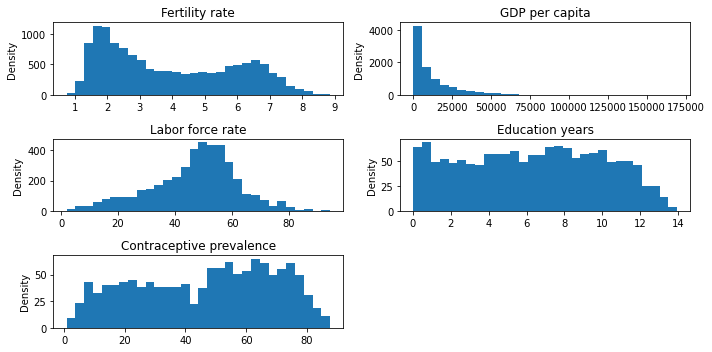

In [13]:
col_list = ['Fertility rate', 'GDP per capita', 'Labor force rate', 'Education years', 'Contraceptive prevalence']

plt.figure(figsize=(10,5))
for idx in range(len(col_list)):
    plt.subplot(3,2,idx+1)
    plt.hist(merged_df[col_list[idx]], bins=30)
    plt.ylabel('Density')
    plt.title(f'{col_list[idx]}')
plt.tight_layout()
plt.show()

## Model

In [14]:
#TODO Specify two models
#TODO Explain difference between two models
#TODO Is the difference justified?
#TODO Are models sufficiently described?

## Priors

In [15]:
prior_df = merged_df.drop(columns='Education years').dropna()

### GDP

In [215]:
gdp_prior = CmdStanModel(stan_file='prior_gdp.stan')

INFO:cmdstanpy:compiling stan file /home/projekt/prior_gdp.stan to exe file /home/projekt/prior_gdp
INFO:cmdstanpy:compiled model executable: /home/projekt/prior_gdp


In [337]:
data_simulation_gdp = {
    'N': len(prior_df),
    'gdp_per_capita': prior_df['GDP per capita'].values/1000,
    'mu_alpha': np.log(prior_df['Fertility rate'].mean()),
    'sig_alpha': np.log(prior_df['Fertility rate'].std()),
    'mu_beta': 0.1,
    'sig_beta': 0.05,
    'shape' : 3,
    'rate' : 1.75
}

In [338]:
R = len(prior_df)

sim_gdp = gdp_prior.sample(data=data_simulation_gdp, iter_warmup=500, iter_sampling=R, chains=1, seed=2001)
sim_gdp_df = sim_gdp.draws_pd()

INFO:cmdstanpy:CmdStan start processing
chain 1 |          | 00:00 Status

chain 1 |██████████| 00:00 Sampling completed                       


INFO:cmdstanpy:CmdStan done processing.


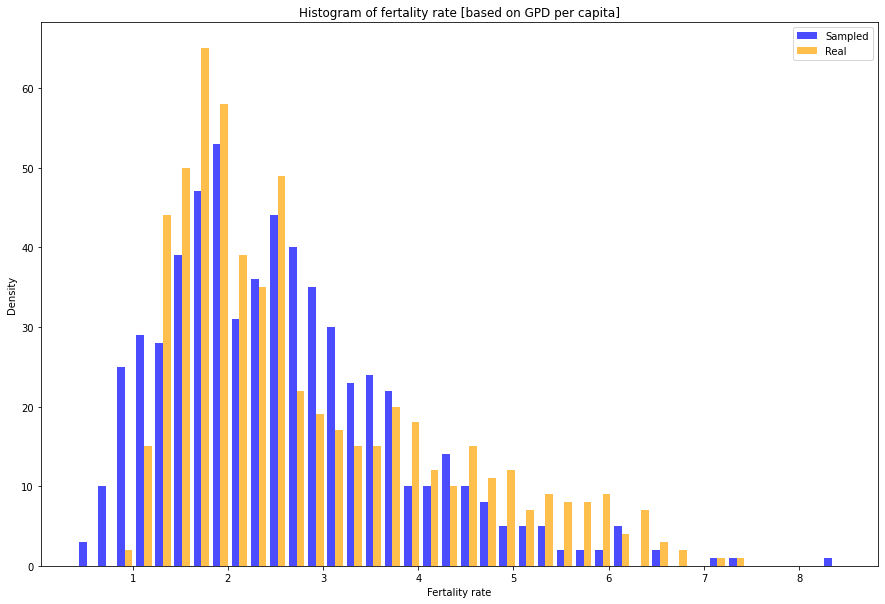

In [339]:
plt.figure(figsize=(15,10))
plt.title('Histogram of fertality rate [based on GPD per capita]')
plt.hist([sim_gdp_df['y_pred[2]'], prior_df['Fertility rate']], bins=40, alpha=0.7, label=['Sampled', 'Real'], color=['blue', 'orange'])
plt.legend()
plt.ylabel('Density')
plt.xlabel('Fertality rate')
plt.show()

### Labor force

In [361]:
percentage_prior = CmdStanModel(stan_file='prior_percentage.stan')

INFO:cmdstanpy:compiling stan file /home/projekt/prior_percentage.stan to exe file /home/projekt/prior_percentage
INFO:cmdstanpy:compiled model executable: /home/projekt/prior_percentage


In [416]:
data_simulation_labor = {
    'N': len(prior_df),
    'percentage_values': prior_df['Labor force rate'],
    'mu_alpha': np.log(prior_df['Fertility rate'].mean()),
    'sig_alpha': np.log(prior_df['Fertility rate'].std()),
    'mu_beta': 0.1,
    'sig_beta': 0.05,
    'shape' : 4.1,
    'rate' : 2
}

In [417]:
R = len(prior_df)

sim_labor = percentage_prior.sample(data=data_simulation_labor, iter_warmup=500, iter_sampling=R, chains=1, seed=2001)
sim_labor_df = sim_labor.draws_pd()

INFO:cmdstanpy:CmdStan start processing
chain 1 |██████████| 00:00 Sampling completed                       


INFO:cmdstanpy:CmdStan done processing.


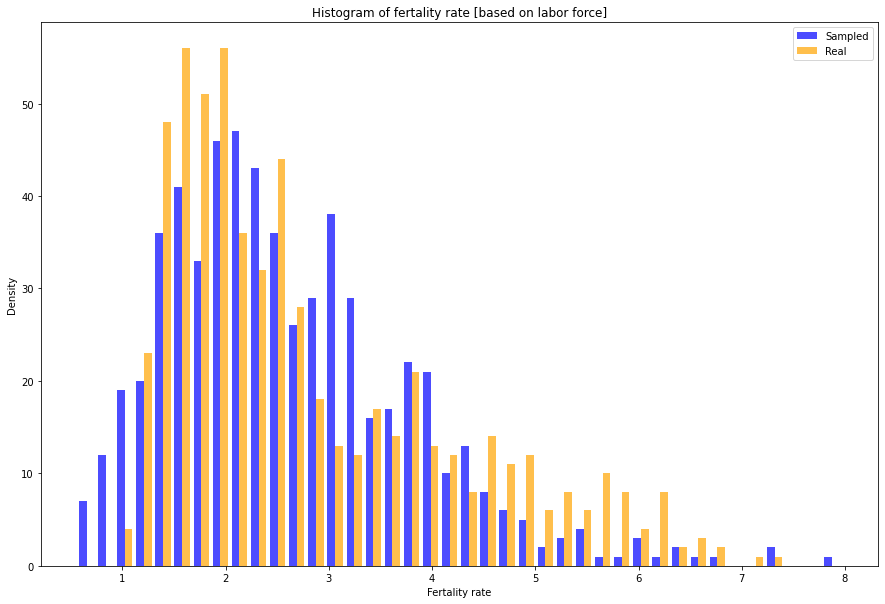

In [418]:
plt.figure(figsize=(15,10))
plt.title('Histogram of fertality rate [based on labor force]')
plt.hist([sim_labor_df['y_pred[2]'], prior_df['Fertility rate']], bins=40, alpha=0.7, label=['Sampled', 'Real'], color=['blue', 'orange'])
plt.legend()
plt.ylabel('Density')
plt.xlabel('Fertality rate')
plt.show()

### Contraception

In [436]:
data_simulation_contra = {
    'N': len(prior_df),
    'percentage_values': prior_df['Contraceptive prevalence'],
    'mu_alpha': np.log(prior_df['Fertility rate'].mean()),
    'sig_alpha': np.log(prior_df['Fertility rate'].std()),
    'mu_beta': 0.1,
    'sig_beta': 0.05,
    'shape' : 4.1,
    'rate' : 2.2
}

In [437]:
R = len(prior_df)

sim_contra = percentage_prior.sample(data=data_simulation_contra, iter_warmup=500, iter_sampling=R, chains=1, seed=2001)
sim_contra_df = sim_contra.draws_pd()

INFO:cmdstanpy:CmdStan start processing
chain 1 |██████████| 00:00 Sampling completed                       


INFO:cmdstanpy:CmdStan done processing.


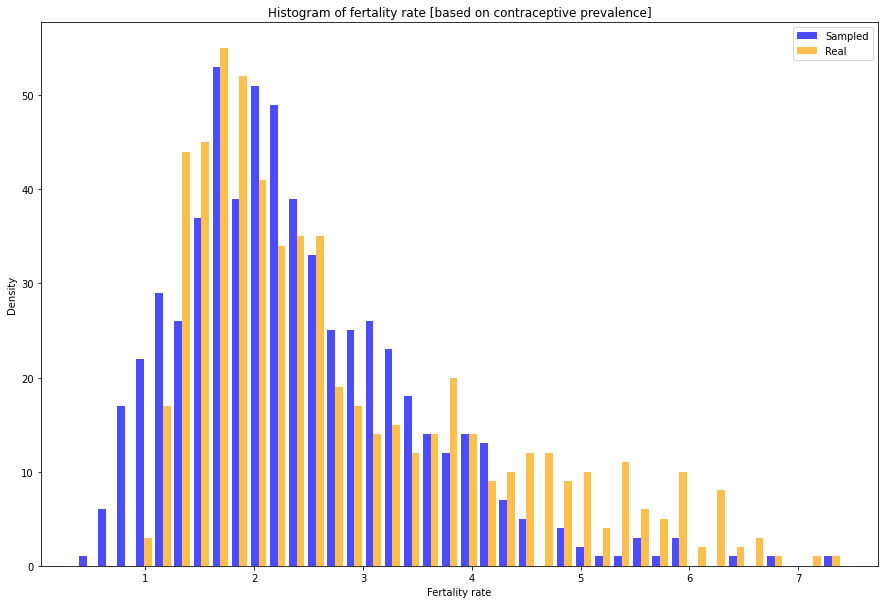

In [438]:
plt.figure(figsize=(15,10))
plt.title('Histogram of fertality rate [based on contraceptive prevalence]')
plt.hist([sim_contra_df['y_pred[2]'], prior_df['Fertility rate']], bins=40, alpha=0.7, label=['Sampled', 'Real'], color=['blue', 'orange'])
plt.legend()
plt.ylabel('Density')
plt.xlabel('Fertality rate')
plt.show()


In [439]:
#TODO Explain which priors where chosen and why?
#TODO Have prior predictive checks been done for parameters? (simulated parameters makes sense)
#TODO Have prior predictive checks been done for measurements? (simulated measurments makes sense)
#TODO How prior parameters were selected?

## Posterios analysis - model 1

In [454]:
gdp_posterior = CmdStanModel(stan_file='posterior_gdp.stan')

INFO:cmdstanpy:found newer exe file, not recompiling


In [478]:
data_simulation_gdp_post = {
    'N': len(prior_df),
    'gdp_per_capita': prior_df['GDP per capita'].values/1000,
    'fertility_rate' : prior_df['Fertility rate'].values,
    'mu_alpha': np.log(prior_df['Fertility rate'].mean()),
    'sig_alpha': np.log(prior_df['Fertility rate'].std()),
    'mu_beta': 0.1,
    'sig_beta': 0.05,
    'shape' : 1.4,
    'rate' : 1.55
}

In [479]:
R = len(prior_df)

sim_post_gdp = gdp_posterior.sample(data=data_simulation_gdp_post, iter_warmup=500, iter_sampling=R, chains=1, seed=2001)
sim_post_gdp_df = sim_post_gdp.draws_pd()

INFO:cmdstanpy:CmdStan start processing
chain 1 |██████████| 00:02 Sampling completed                       


INFO:cmdstanpy:CmdStan done processing.


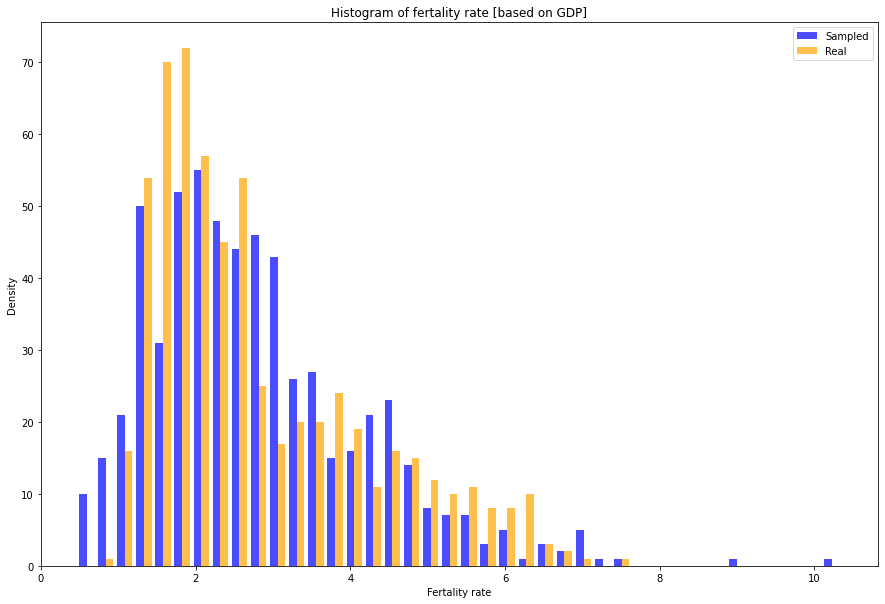

In [480]:
plt.figure(figsize=(15,10))
plt.title('Histogram of fertality rate [based on GDP]')
plt.hist([sim_post_gdp_df['y_pred[2]'], prior_df['Fertility rate']], bins=40, alpha=0.7, label=['Sampled', 'Real'], color=['blue', 'orange'])
plt.legend()
plt.ylabel('Density')
plt.xlabel('Fertality rate')
plt.show()

In [458]:
#TODO Any issues with sampling? If so, what ideas of mitigation were used?
#TODO Are samples analyzed?
#TODO Are the data consistent with posterior predictive samples and is it commented sufficiently? (if not is there justification)
#TODO Have parameter marginal disrtibutions been analyzed (histograms of individual parametes plus summaries, are they diffuse or concentrated, what can we say about values)

## Posterior analysis - model 2

In [462]:
posterior_combined = CmdStanModel(stan_file='posterior_combined.stan')

INFO:cmdstanpy:compiling stan file /home/projekt/posterior_combined.stan to exe file /home/projekt/posterior_combined
INFO:cmdstanpy:compiled model executable: /home/projekt/posterior_combined


In [493]:
data_simulation_posterior_combined = {
    'N': len(prior_df),
    'gdp_per_capita': prior_df['GDP per capita'].values/1000,
    'labor_force' : prior_df['Labor force rate'],
    'contaceptive_prevalence' : prior_df['Contraceptive prevalence'], 
    'fertility_rate' : prior_df['Fertility rate'].values,
    'mu_alpha': np.log(prior_df['Fertility rate'].mean()),
    'sig_alpha': np.log(prior_df['Fertility rate'].std()),
    'mu_beta': 0.1,
    'sig_beta': 0.05,
    'shape' : 2,
    'rate' : 1.75
}

In [494]:
R = len(prior_df)

sim_combined = posterior_combined.sample(data=data_simulation_posterior_combined, iter_warmup=500, iter_sampling=R, chains=1, seed=2001)
sim_post_gdp_df = sim_combined.draws_pd()

INFO:cmdstanpy:CmdStan start processing
chain 1 |          | 00:00 Status

chain 1 |██████████| 00:06 Sampling completed                       


INFO:cmdstanpy:CmdStan done processing.


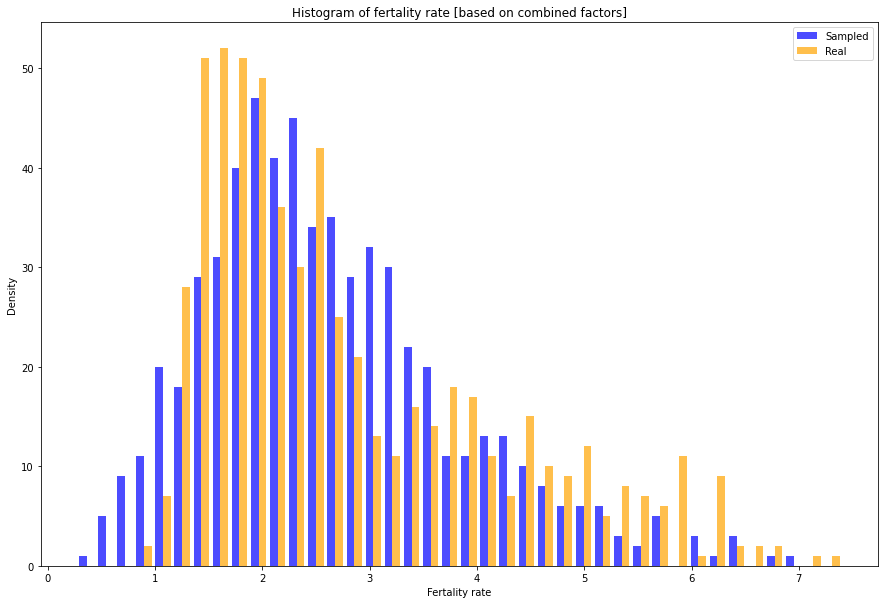

In [498]:
plt.figure(figsize=(15,10))
plt.title('Histogram of fertality rate [based on combined factors]')
plt.hist([sim_post_gdp_df['y_pred[2]'], prior_df['Fertility rate']], bins=40, alpha=0.7, label=['Sampled', 'Real'], color=['blue', 'orange'])
plt.legend()
plt.ylabel('Density')
plt.xlabel('Fertality rate')
plt.show()

In [496]:
#TODO Any issues with sampling? If so, what ideas of mitigation were used?
#TODO Are samples analyzed?
#TODO Are the data consistent with posterior predictive samples and is it commented sufficiently? (if not is there justification)
#TODO Have parameter marginal disrtibutions been analyzed (histograms of individual parametes plus summaries, are they diffuse or concentrated, what can we say about values)

## Model comparision

In [497]:
#TODO Have models been compared using information criteria
#TODO Have result for WAIC been discussed (is there a clear winner, or is there an overlap, were there any warnings)
#TODO Have result for PSIS-LOO been discussed (is there a clear winner, or is there an overlap, were there any warnings)
#TODO Whas the model comparison discussed? Do authors agree with information criteria? Why in your opinion one model better than another